In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.torch_core import *
from fastai.callback import *
from fastai.basic_train import *
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
import torchvision
from fastai.callbacks import *
from scipy import ndimage
import pickle

dfFile = "/home/santhosr/Documents/Birad/FastAI/RaceClassification/DataFile5.csv"

modelName = 'model_resnet50_id6_acc823_loss449'


#Feature Directories
trainFolder = '/home/santhosr/Documents/Birad/FastAI/RaceClassification/Features/model6/train'

validFolder = '/home/santhosr/Documents/Birad/FastAI/RaceClassification/Features/model6/valid'

def getRaceLabel(x,binary=False):
    ID = x.split("/")[-1].split("_")[0]
    label = truth[truth.DummyID == int(ID)]['Medview_Race'].values[0]

    if label == 'African American':
        return 0
    elif label == "White":
        return 1
    else:
        return 2
 

In [2]:
   

truthFile = '/home/santhosr/Documents/Birad/birad_targetFile.csv'
truth = pd.read_csv(truthFile)

df = pd.read_csv(dfFile)

final = pd.read_csv("/home/santhosr/Documents/Birad/FastAI/RaceClassification/Final.csv")
keepList = ['ImageName','VolumetricBreastDensity','DenseAreaPercent']
final = final[keepList]

df['ImageName'] = df.files.apply(lambda x : x.split(".")[0].split("/")[1])

#merging with final to retrieve the density metrics
df = pd.merge(df, final, on='ImageName',how='left')

#removing instances which dont have breast density values
df = df.loc[~pd.isna(df.VolumetricBreastDensity)]
    

In [3]:
data = ImageItemList.from_df(df=df,path='/home/santhosr/Documents/Birad/ProcessedData/FullRes/', cols='files').split_from_df(col='train').label_from_func(getRaceLabel).transform(get_transforms(),size=256).databunch(bs=100).normalize()
print("Dataset created")

learn = create_cnn(data, models.resnet50, metrics=accuracy,pretrained=True)

learn.load('/home/santhosr/Documents/Birad/ProcessedData/models/'+modelName)



Dataset created


Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (12326 items)
[Category 1, Category 0, Category 1, Category 0, Category 0]...
Path: /home/santhosr/Documents/Birad/ProcessedData/FullRes
x: ImageItemList (12326 items)
[Image (3, 4096, 3328), Image (3, 4096, 3328), Image (3, 3328, 2560), Image (3, 3328, 2560), Image (3, 4096, 3328)]...
Path: /home/santhosr/Documents/Birad/ProcessedData/FullRes;

Valid: LabelList
y: CategoryList (3091 items)
[Category 1, Category 0, Category 1, Category 1, Category 1]...
Path: /home/santhosr/Documents/Birad/ProcessedData/FullRes
x: ImageItemList (3091 items)
[Image (3, 4096, 3328), Image (3, 4096, 3328), Image (3, 3328, 2560), Image (3, 4096, 3328), Image (3, 4096, 3328)]...
Path: /home/santhosr/Documents/Birad/ProcessedData/FullRes;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

### Fastai GradCam

In [11]:
class GradCam():
    @classmethod
    def from_interp(cls,learn,interp,img_idx,ds_type=DatasetType.Valid,include_label=False):
        # produce heatmap and xb_grad for pred label (and actual label if include_label is True)
        if ds_type == DatasetType.Valid:
            ds = interp.data.valid_ds
        elif ds_type == DatasetType.Test:
            ds = interp.data.test_ds
            include_label=False
        elif ds_type == DatasetType.Train:
            ds = interp.data.train_ds
        else:
            return None
        
        x_img = ds.x[img_idx]
        xb,_ = interp.data.one_item(x_img)
        xb_img = Image(interp.data.denorm(xb)[0])
        probs = interp.probs[img_idx].numpy()

        pred_idx = interp.pred_class[img_idx].item() # get class idx of img prediction label
        hmap_pred,xb_grad_pred = get_grad_heatmap(learn,xb,pred_idx,size=xb_img.shape[-1])
        prob_pred = probs[pred_idx]
        
        actual_args=None
        if include_label:
            actual_idx = ds.y.items[img_idx] # get class idx of img actual label
            if actual_idx!=pred_idx:
                hmap_actual,xb_grad_actual = get_grad_heatmap(learn,xb,actual_idx,size=xb_img.shape[-1])
                prob_actual = probs[actual_idx]
                actual_args=[interp.data.classes[actual_idx],prob_actual,hmap_actual,xb_grad_actual]
        
        return cls(xb_img,interp.data.classes[pred_idx],prob_pred,hmap_pred,xb_grad_pred,actual_args)
    
    @classmethod
    def from_one_img(cls,learn,x_img,label1=None,label2=None):
        '''
        learn: fastai's Learner
        x_img: fastai.vision.image.Image
        label1: generate heatmap according to this label. If None, this wil be the label with highest probability from the model
        label2: generate additional heatmap according to this label
        '''
        pred_class,pred_idx,probs = learn.predict(x_img)
        label1= str(pred_class) if not label1 else label1
        
        xb,_ = learn.data.one_item(x_img)
        xb_img = Image(learn.data.denorm(xb)[0])
        probs = probs.numpy()
        
        label1_idx = learn.data.classes.index(label1)
        hmap1,xb_grad1 = get_grad_heatmap(learn,xb,label1_idx,size=xb_img.shape[-1])
        prob1 = probs[label1_idx]
        
        label2_args = None
        if label2:
            label2_idx = learn.data.classes.index(label2)
            hmap2,xb_grad2 = get_grad_heatmap(learn,xb,label2_idx,size=xb_img.shape[-1])
            prob2 = probs[label2_idx]
            label2_args = [label2,prob2,hmap2,xb_grad2]
            
        return cls(xb_img,label1,prob1,hmap1,xb_grad1,label2_args)
    
    def __init__(self,xb_img,label1,prob1,hmap1,xb_grad1,label2_args=None):
        self.xb_img=xb_img
        self.label1,self.prob1,self.hmap1,self.xb_grad1 = label1,prob1,hmap1,xb_grad1
        if label2_args:
            self.label2,self.prob2,self.hmap2,self.xb_grad2 = label2_args
            
    def plot(self,plot_hm=True,plot_gbp=True):
        if not plot_hm and not plot_gbp:
            plot_hm=True
        cols = 5 if hasattr(self, 'label2') else 3
        if not plot_gbp or not plot_hm:
            cols-= 2 if hasattr(self, 'label2') else 1

        fig,row_axes = plt.subplots(1,cols,figsize=(cols*5,5))  
        col=0
        size=self.xb_img.shape[-1]
        self.xb_img.show(row_axes[col]);col+=1
        
        label1_title = f'1.{self.label1} {self.prob1:.3f}'
        if plot_hm:
            show_heatmap(self.hmap1,self.xb_img,size,row_axes[col])
            row_axes[col].set_title(label1_title);col+=1
        if plot_gbp:
            row_axes[col].imshow(self.xb_grad1)
            row_axes[col].set_axis_off()
            row_axes[col].set_title(label1_title);col+=1
        
        if hasattr(self, 'label2'):
            label2_title = f'2.{self.label2} {self.prob2:.3f}'
            if plot_hm:
                show_heatmap(self.hmap2,self.xb_img,size,row_axes[col])
                row_axes[col].set_title(label2_title);col+=1
            if plot_gbp:
                row_axes[col].imshow(self.xb_grad2)
                row_axes[col].set_axis_off()
                row_axes[col].set_title(label2_title)
        # plt.tight_layout()
        fig.subplots_adjust(wspace=0, hspace=0)
        # fig.savefig('data_draw/both/gradcam.png')

def minmax_norm(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))
def scaleup(x,size):
    scale_mult=size/x.shape[0]
    upsampled = scipy.ndimage.zoom(x, scale_mult)
    return upsampled

# hook for Gradcam
def hooked_backward(m,xb,target_layer,clas):
    with hook_output(target_layer) as hook_a: #hook at last layer of group 0's output (after bn, size 512x7x7 if resnet34)
        with hook_output(target_layer, grad=True) as hook_g: # gradient w.r.t to the target_layer
            preds = m(xb)
            preds[0,int(clas)].backward() # same as onehot backprop
    return hook_a,hook_g

def clamp_gradients_hook(module, grad_in, grad_out):
    for grad in grad_in:
        torch.clamp_(grad, min=0.0)
        
# hook for guided backprop
def hooked_ReLU(m,xb,clas):
    relu_modules = [module[1] for module in m.named_modules() if str(module[1]) == "ReLU(inplace)"]
    with callbacks.Hooks(relu_modules, clamp_gradients_hook, is_forward=False) as _:
        preds = m(xb)
        preds[0,int(clas)].backward()
        
def guided_backprop(learn,xb,y):
    xb = xb.cuda()
    m = learn.model.eval();
    xb.requires_grad_();
    if not xb.grad is None:
        xb.grad.zero_(); 
    hooked_ReLU(m,xb,y);
    return xb.grad[0].cpu().numpy()

def show_heatmap(hm,xb_im,size,ax=None):
    if ax is None:
        _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.8, extent=(0,size,size,0),
              interpolation='bilinear',cmap='magma');

def get_grad_heatmap(learn,xb,y,size):
    '''
    Main function to get hmap for heatmap and xb_grad for guided backprop
    '''
    xb = xb.cuda()
    m = learn.model.eval();
    target_layer = m[0][-1][-1] # last layer of group 0
    hook_a,hook_g = hooked_backward(m,xb,target_layer,y)
    
    target_act= hook_a.stored[0].cpu().numpy()
    target_grad = hook_g.stored[0][0].cpu().numpy()
    
    mean_grad = target_grad.mean(1).mean(1)
#     hmap = (target_act*mean_grad[...,None,None]).mean(0)
    hmap = (target_act*mean_grad[...,None,None]).sum(0)
    hmap = np.where(hmap >= 0, hmap, 0)
    
    xb_grad = guided_backprop(learn,xb,y) # (3,224,224)        
    #minmax norm the grad
    xb_grad = minmax_norm(xb_grad)
    hmap_scaleup = minmax_norm(scaleup(hmap,size)) # (224,224)
    
    # multiply xb_grad and hmap_scaleup and switch axis
    xb_grad = np.einsum('ijk, jk->jki',xb_grad, hmap_scaleup) #(224,224,3)
    
    return hmap,xb_grad

### Testing

In [4]:
import pickle
from imageio import imread,imsave
from scipy.misc import imresize
from tqdm import tqdm



In [5]:
gradCamFolder = '/home/santhosr/Documents/Birad/FastAI/RaceClassification/Visualization/GradCAM_Outputs/'
guidedBackFolder = '/home/santhosr/Documents/Birad/FastAI/RaceClassification/Visualization/GuidedBack_Outputs/'


In [15]:
interp = ClassificationInterpretation.from_learner(learn,ds_type = DatasetType.Train)

In [16]:
errorList = []

for i in tqdm(range(len(data.train_ds))):
    
    try:
        gcam = GradCam.from_interp(learn,interp,i, DatasetType.Train ) #image_idx from ds.train_ds or ds.test_ds

        filename = data.train_ds.items[i].split("/")[-1].split(".")[0]

        #GradCAM output
        #         GradCamPlot = gcam.hmap1
        #         GradCamPlot = imresize(GradCamPlot, (256,256))
        #         pickle.dump(GradCamPlot, open(gradCamFolder + filename + '.p', "wb"))

        #Guided BackProp output
        GuidedBackPlot = gcam.xb_grad1
        pickle.dump(GuidedBackPlot, open(guidedBackFolder + filename + '.p','wb'))

    except:
        errorList.append(data.train_ds.items[i])
        print(data.train_ds.items[i])



    


  1%|          | 147/12326 [00:41<56:29,  3.59it/s]


  2%|▏         | 294/12326 [01:22<1:00:24,  3.32it/s]


  4%|▎         | 440/12326 [02:04<50:54,  3.89it/s]


  5%|▍         | 587/12326 [02:45<54:43,  3.58it/s]  


  6%|▌         | 734/12326 [03:27<56:48,  3.40it/s]


  7%|▋         | 882/12326 [04:08<57:58,  3.29it/s]


  8%|▊         | 1029/12326 [04:49<58:47,  3.20it/s]


 10%|▉         | 1174/12326 [05:30<43:25,  4.28it/s]


 11%|█         | 1320/12326 [06:12<51:25,  3.57it/s]


 12%|█▏        | 1466/12326 [06:54<45:08,  4.01it/s]


 13%|█▎        | 1612/12326 [07:35<48:26,  3.69it/s]


 14%|█▍        | 1758/12326 [08:17<49:13,  3.58it/s]


 15%|█▌        | 1904/12326 [08:57<57:38,  3.01it/s]


 17%|█▋        | 2050/12326 [09:40<52:50,  3.24it/s]


 18%|█▊        | 2196/12326 [10:20<50:46,  3.32it/s]


 19%|█▉        | 2342/12326 [11:02<42:36,  3.91it/s]


 20%|██        | 2488/12326 [11:44<49:09,  3.34it/s]


 21%|██▏       | 2634/12326 [12:24<43:40,  3.70it/s]


 23%|██▎       | 2780/12326 [13:05<46:05,  3.45it/s]


 24%|██▎       | 2926/12326 [13:47<37:19,  4.20it/s]


 25%|██▍       | 3072/12326 [14:30<48:18,  3.19it/s]


 26%|██▌       | 3218/12326 [15:16<52:43,  2.88it/s]


 27%|██▋       | 3364/12326 [15:58<41:28,  3.60it/s]


 28%|██▊       | 3510/12326 [16:37<40:29,  3.63it/s]


 30%|██▉       | 3656/12326 [17:19<40:04,  3.61it/s]


 31%|███       | 3802/12326 [18:00<38:25,  3.70it/s]


 32%|███▏      | 3948/12326 [18:40<39:11,  3.56it/s]


 33%|███▎      | 4094/12326 [19:21<38:33,  3.56it/s]


 34%|███▍      | 4240/12326 [20:02<32:44,  4.12it/s]


 36%|███▌      | 4386/12326 [20:42<35:23,  3.74it/s]


 37%|███▋      | 4532/12326 [21:23<38:36,  3.36it/s]


 38%|███▊      | 4678/12326 [22:02<34:19,  3.71it/s]


 39%|███▉      | 4824/12326 [22:43<35:08,  3.56it/s]


 40%|████      | 4970/12326 [23:24<34:53,  3.51it/s]


 42%|████▏     | 5116/12326 [24:02<35:41,  3.37it/s]


 43%|████▎     | 5262/12326 [24:44<38:02,  3.09it/s]


 44%|████▍     | 5408/12326 [25:25<33:16,  3.47it/s]


 45%|████▌     | 5554/12326 [26:06<31:10,  3.62it/s]


 46%|████▌     | 5700/12326 [26:46<26:51,  4.11it/s]


 47%|████▋     | 5846/12326 [27:27<31:21,  3.44it/s]


 49%|████▊     | 5992/12326 [28:08<30:55,  3.41it/s]


 50%|████▉     | 6138/12326 [28:49<28:58,  3.56it/s]


 51%|█████     | 6284/12326 [29:31<30:08,  3.34it/s]


 52%|█████▏    | 6430/12326 [30:10<22:43,  4.32it/s]


 53%|█████▎    | 6576/12326 [30:51<26:20,  3.64it/s]


 55%|█████▍    | 6722/12326 [31:32<26:05,  3.58it/s]


 56%|█████▌    | 6868/12326 [32:12<21:12,  4.29it/s]


 57%|█████▋    | 7014/12326 [32:52<25:00,  3.54it/s]


 58%|█████▊    | 7160/12326 [33:31<23:54,  3.60it/s]


 59%|█████▉    | 7306/12326 [34:13<21:43,  3.85it/s]


 60%|██████    | 7452/12326 [34:53<18:49,  4.32it/s]


 62%|██████▏   | 7598/12326 [35:33<25:40,  3.07it/s]


 63%|██████▎   | 7744/12326 [36:14<23:32,  3.24it/s]


 64%|██████▍   | 7890/12326 [36:54<18:01,  4.10it/s]


 65%|██████▌   | 8036/12326 [37:35<17:47,  4.02it/s]


 66%|██████▋   | 8182/12326 [38:16<20:13,  3.41it/s]


 68%|██████▊   | 8328/12326 [38:58<20:03,  3.32it/s]


 69%|██████▊   | 8474/12326 [39:38<20:26,  3.14it/s]


 70%|██████▉   | 8620/12326 [40:19<17:14,  3.58it/s]


 71%|███████   | 8766/12326 [41:00<14:13,  4.17it/s]


 72%|███████▏  | 8912/12326 [41:41<14:12,  4.01it/s]


 73%|███████▎  | 9058/12326 [42:22<14:55,  3.65it/s]


 75%|███████▍  | 9204/12326 [43:01<14:43,  3.53it/s]


 76%|███████▌  | 9350/12326 [43:42<12:59,  3.82it/s]


 77%|███████▋  | 9496/12326 [44:23<14:30,  3.25it/s]


 78%|███████▊  | 9642/12326 [45:03<13:45,  3.25it/s]


 79%|███████▉  | 9788/12326 [45:44<11:11,  3.78it/s]


 81%|████████  | 9934/12326 [46:26<11:51,  3.36it/s]


 82%|████████▏ | 10078/12326 [47:05<10:55,  3.43it/s]


 83%|████████▎ | 10221/12326 [47:44<09:50,  3.57it/s]


 84%|████████▍ | 10364/12326 [48:25<08:03,  4.06it/s]


 85%|████████▌ | 10507/12326 [49:03<07:42,  3.93it/s]


 86%|████████▋ | 10650/12326 [49:43<08:03,  3.47it/s]


 88%|████████▊ | 10793/12326 [50:24<07:59,  3.20it/s]


 89%|████████▊ | 10936/12326 [51:06<06:31,  3.55it/s]


 90%|████████▉ | 11079/12326 [51:47<06:43,  3.09it/s]


 91%|█████████ | 11222/12326 [52:27<04:56,  3.72it/s]


 92%|█████████▏| 11365/12326 [53:07<04:34,  3.50it/s]


 93%|█████████▎| 11508/12326 [53:49<03:47,  3.59it/s]


 95%|█████████▍| 11651/12326 [54:28<02:49,  3.98it/s]


 96%|█████████▌| 11794/12326 [55:08<02:24,  3.67it/s]


 97%|█████████▋| 11937/12326 [55:49<01:55,  3.37it/s]


 98%|█████████▊| 12080/12326 [56:28<01:12,  3.41it/s]


 99%|█████████▉| 12223/12326 [57:09<00:29,  3.52it/s]


100%|█████████▉| 12302/12326 [57:31<00:05,  4.36it/s]

/home/santhosr/Documents/Birad/ProcessedData/FullRes/./3/76314216_L_MLO_1.jpg
/home/santhosr/Documents/Birad/ProcessedData/FullRes/./4/75255455_L_CC_1.jpg



100%|█████████▉| 12303/12326 [57:31<00:04,  4.78it/s]

/home/santhosr/Documents/Birad/ProcessedData/FullRes/./2/4784670_R_MLO_1.jpg



100%|█████████▉| 12304/12326 [57:32<00:04,  4.46it/s]

/home/santhosr/Documents/Birad/ProcessedData/FullRes/./2/75914199_R_MLO_1.jpg



100%|█████████▉| 12305/12326 [57:32<00:04,  4.25it/s]

/home/santhosr/Documents/Birad/ProcessedData/FullRes/./2/76790593_R_CC_1.jpg



100%|█████████▉| 12307/12326 [57:32<00:04,  4.58it/s]

/home/santhosr/Documents/Birad/ProcessedData/FullRes/./2/75031100_L_CC_1.jpg
/home/santhosr/Documents/Birad/ProcessedData/FullRes/./3/76706171_L_CC_1.jpg



100%|█████████▉| 12308/12326 [57:32<00:03,  4.96it/s]

/home/santhosr/Documents/Birad/ProcessedData/FullRes/./2/75566987_L_CC_1.jpg



100%|█████████▉| 12309/12326 [57:33<00:03,  4.54it/s]

/home/santhosr/Documents/Birad/ProcessedData/FullRes/./2/3696737_R_MLO_1.jpg



100%|█████████▉| 12311/12326 [57:33<00:03,  4.71it/s]

/home/santhosr/Documents/Birad/ProcessedData/FullRes/./1/3014599_R_CC_1.jpg
/home/santhosr/Documents/Birad/ProcessedData/FullRes/./2/4760828_L_MLO_1.jpg



100%|█████████▉| 12312/12326 [57:33<00:03,  4.40it/s]

/home/santhosr/Documents/Birad/ProcessedData/FullRes/./2/3591454_L_MLO_1.jpg



100%|█████████▉| 12313/12326 [57:34<00:03,  4.20it/s]

/home/santhosr/Documents/Birad/ProcessedData/FullRes/./1/75132636_L_CC_1.jpg



100%|█████████▉| 12314/12326 [57:34<00:02,  4.05it/s]

/home/santhosr/Documents/Birad/ProcessedData/FullRes/./2/75716389_R_MLO_1.jpg



100%|█████████▉| 12316/12326 [57:34<00:02,  4.46it/s]

/home/santhosr/Documents/Birad/ProcessedData/FullRes/./2/75704168_L_MLO_1.jpg
/home/santhosr/Documents/Birad/ProcessedData/FullRes/./2/75139508_L_CC_1.jpg



100%|█████████▉| 12317/12326 [57:35<00:02,  4.24it/s]

/home/santhosr/Documents/Birad/ProcessedData/FullRes/./2/76089274_L_MLO_1.jpg



100%|█████████▉| 12319/12326 [57:35<00:01,  4.59it/s]

/home/santhosr/Documents/Birad/ProcessedData/FullRes/./2/75516871_R_CC_1.jpg
/home/santhosr/Documents/Birad/ProcessedData/FullRes/./3/75363329_R_MLO_1.jpg



100%|█████████▉| 12321/12326 [57:35<00:00,  5.28it/s]

/home/santhosr/Documents/Birad/ProcessedData/FullRes/./3/75061014_R_MLO_1.jpg
/home/santhosr/Documents/Birad/ProcessedData/FullRes/./3/76607116_L_CC_1.jpg



100%|█████████▉| 12322/12326 [57:36<00:00,  4.72it/s]

/home/santhosr/Documents/Birad/ProcessedData/FullRes/./3/4842353_R_MLO_1.jpg



100%|█████████▉| 12324/12326 [57:36<00:00,  4.84it/s]

/home/santhosr/Documents/Birad/ProcessedData/FullRes/./3/76541601_R_CC_1.jpg
/home/santhosr/Documents/Birad/ProcessedData/FullRes/./2/76684902_L_MLO_1.jpg



100%|██████████| 12326/12326 [57:36<00:00,  5.48it/s]


/home/santhosr/Documents/Birad/ProcessedData/FullRes/./4/4711582_L_CC_1.jpg
/home/santhosr/Documents/Birad/ProcessedData/FullRes/./2/76013329_R_CC_1.jpg


In [9]:
len(errorList)

12326

In [47]:
a = pickle.load(open('/home/santhosr/Documents/Birad/FastAI/RaceClassification/Visualization/GradCAM_Outputs/77082509_R_CC_1.p','rb'))

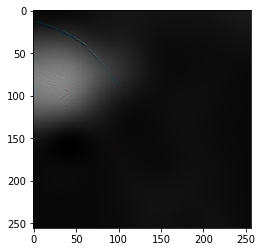

In [48]:
plt.imshow(a)

In [49]:
a

array([[[0.034704, 0.035297, 0.035265],
        [0.034188, 0.035165, 0.035495],
        [0.034307, 0.034299, 0.034963],
        [0.034659, 0.033895, 0.034378],
        ...,
        [0.09776 , 0.098014, 0.098133],
        [0.098081, 0.098089, 0.097982],
        [0.098539, 0.098514, 0.09817 ],
        [0.098123, 0.098174, 0.098079]],

       [[0.034648, 0.035392, 0.035616],
        [0.035404, 0.036266, 0.03635 ],
        [0.035446, 0.034761, 0.035176],
        [0.036002, 0.034358, 0.034645],
        ...,
        [0.097931, 0.097955, 0.097867],
        [0.098262, 0.098103, 0.097743],
        [0.098424, 0.098588, 0.098198],
        [0.098239, 0.098693, 0.098522]],

       [[0.035467, 0.034777, 0.035191],
        [0.036446, 0.035243, 0.035531],
        [0.037195, 0.033893, 0.034521],
        [0.037862, 0.033559, 0.03422 ],
        ...,
        [0.098008, 0.097853, 0.09764 ],
        [0.098039, 0.097901, 0.097628],
        [0.097599, 0.098092, 0.098162],
        [0.097372, 0.098193, 0.098481

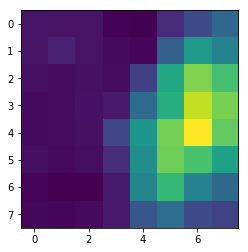

In [15]:
plt.imshow(gcam.hmap1)

In [ ]:
x.imshow(hm, alpha=0.8, extent=(0,size,size,0),
              interpolation='bilinear',cmap='magma')

In [19]:
gcam.xb_grad1.shape

(256, 256, 3)

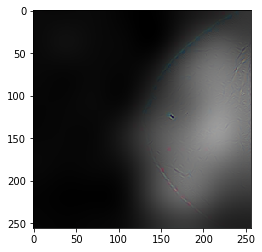

In [21]:
plt.imshow(gcam.xb_grad1)

In [27]:
gcam.xb_grad1

array([[[0.077554, 0.077822, 0.077727],
        [0.077229, 0.07755 , 0.077674],
        [0.077681, 0.076563, 0.077164],
        [0.078302, 0.07689 , 0.07758 ],
        ...,
        [0.208049, 0.207787, 0.208981],
        [0.208595, 0.208336, 0.208782],
        [0.209487, 0.210259, 0.209487],
        [0.20653 , 0.207271, 0.208244]],

       [[0.077125, 0.077108, 0.077215],
        [0.078124, 0.078027, 0.078127],
        [0.078572, 0.076616, 0.07736 ],
        [0.07915 , 0.07649 , 0.077565],
        ...,
        [0.207931, 0.20715 , 0.208909],
        [0.208872, 0.207793, 0.208257],
        [0.210951, 0.212311, 0.210289],
        [0.211172, 0.213187, 0.211746]],

       [[0.077362, 0.075818, 0.07609 ],
        [0.078447, 0.076167, 0.076619],
        [0.079808, 0.074921, 0.076248],
        [0.080671, 0.074726, 0.076452],
        ...,
        [0.208535, 0.207216, 0.210279],
        [0.209476, 0.207441, 0.209316],
        [0.209167, 0.209   , 0.20836 ],
        [0.208387, 0.208864, 0.208465

In [4]:
gcam = GradCam.from_interp(learn,interp,3090) #image_idx from ds.valid_ds or ds.test_ds
gcam.plot() #plot both GradCam and GuidedBackprop. 

NameError: name 'interp' is not defined

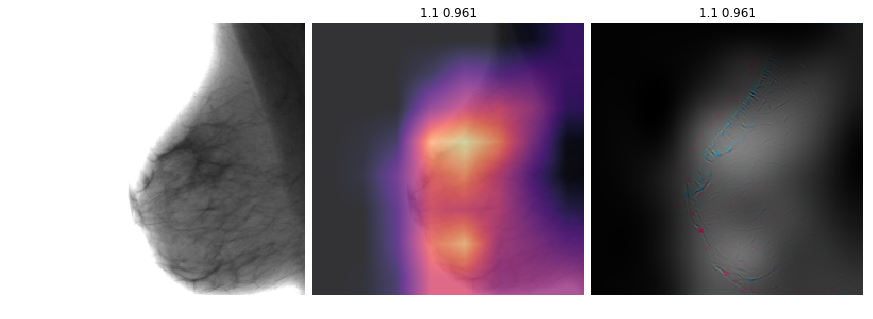

In [11]:
gcam = GradCam.from_interp(learn,interp,2) #image_idx from ds.valid_ds or ds.test_ds
gcam.plot() #plot both GradCam and GuidedBackprop. 

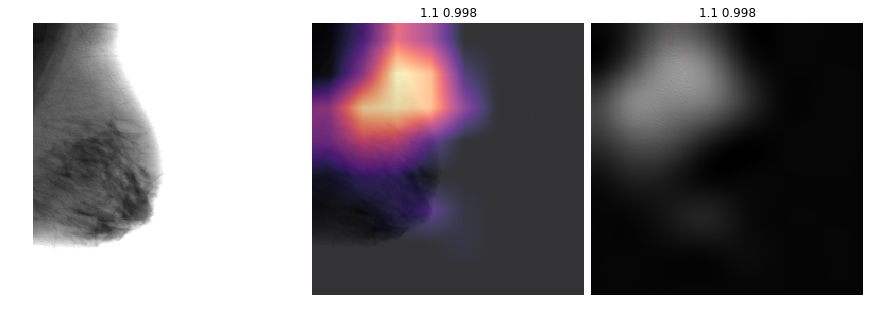

In [12]:
gcam = GradCam.from_interp(learn,interp,3) #image_idx from ds.valid_ds or ds.test_ds
gcam.plot() #plot both GradCam and GuidedBackprop. 

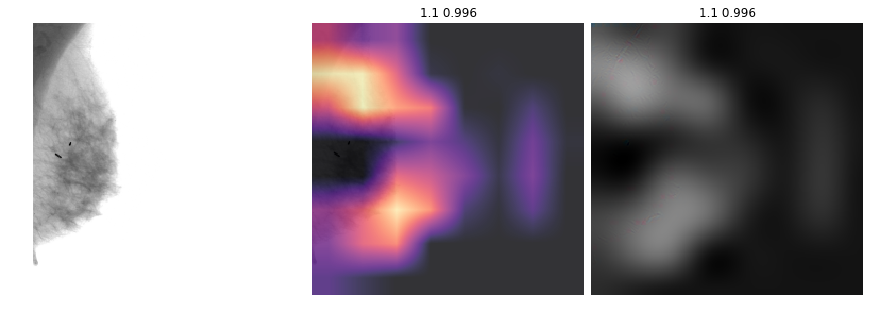

In [13]:
gcam = GradCam.from_interp(learn,interp,4) #image_idx from ds.valid_ds or ds.test_ds
gcam.plot() #plot both GradCam and GuidedBackprop. 

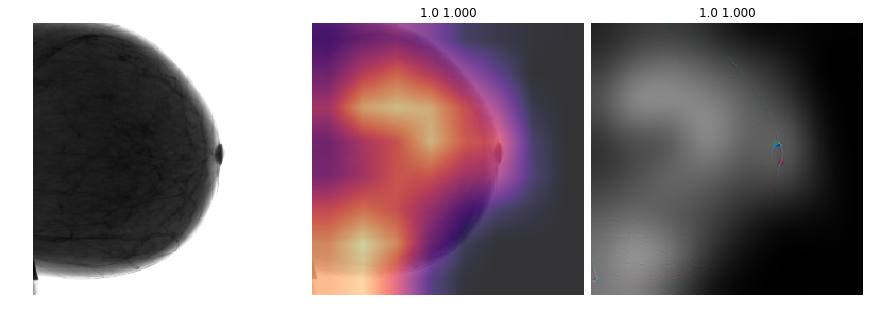

In [15]:
gcam = GradCam.from_interp(learn,interp,6) #image_idx from ds.valid_ds or ds.test_ds
gcam.plot() #plot both GradCam and GuidedBackprop. 

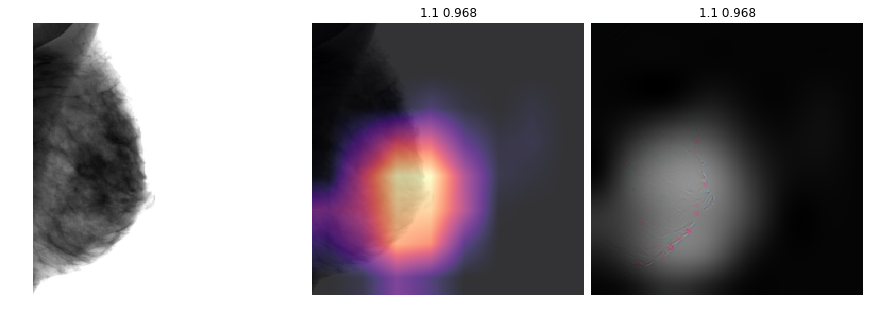

In [16]:
gcam = GradCam.from_interp(learn,interp,7) #image_idx from ds.valid_ds or ds.test_ds
gcam.plot() #plot both GradCam and GuidedBackprop. 

In [ ]:
img = open_image(path_to_image);
gcam = GradCam.from_one_img(learn,img)
gcam.plot()

In [5]:
interp.probs

tensor([[5.6361e-01, 4.3639e-01],
        [9.1337e-01, 8.6627e-02],
        [3.8525e-02, 9.6148e-01],
        ...,
        [9.9753e-01, 2.4713e-03],
        [7.1738e-01, 2.8262e-01],
        [1.6430e-05, 9.9998e-01]])

In [16]:
import torchvision.models as models

In [20]:
densenet = models.resnet50(pretrained=True)

In [21]:
densenet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [19]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

# Old Modules

### Grad CAM


In [3]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

from utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp

In [4]:
##### TESTING CODE
i=23
r=data.one_item(data.valid_ds.x[i])
r[0].requires_grad = True
# target = int(data.valid_dl.y[i])
target = r[1].cpu().numpy()[0]
print(target)

0


In [5]:
model = learn.model

In [49]:
help(model.register_backward_hook)

Help on method register_backward_hook in module torch.nn.modules.module:

register_backward_hook(hook) method of torch.nn.modules.container.Sequential instance
    Registers a backward hook on the module.
    
    The hook will be called every time the gradients with respect to module
    inputs are computed. The hook should have the following signature::
    
        hook(module, grad_input, grad_output) -> Tensor or None
    
    The :attr:`grad_input` and :attr:`grad_output` may be tuples if the
    module has multiple inputs or outputs. The hook should not modify its
    arguments, but it can optionally return a new gradient with respect to
    input that will be used in place of :attr:`grad_input` in subsequent
    computations.
    
    Returns:
        :class:`torch.utils.hooks.RemovableHandle`:
            a handle that can be used to remove the added hook by calling
            ``handle.remove()``
    
    .. warning ::
    
        The current implementation will not have the

In [6]:
class CamExtractor():
    
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.out = None
        self.handles = []
        
        
    def save_gradients(self,grad_in, grad_out,name=None,game=None):
        print(len(grad_out))
        print(type(grad_out))
        self.gradients = (grad_in, grad_out,name,game)
        
    def save_output(self, inp, out,name=None,gave=None):
        print(out.shape)
        self.out = out
        
    def clear_handles(self):
        for i in self.handles:
            i.remove()
        
    def run_forward_pass(self, x):
        
        module1 = list(learn.model._modules.items())[0][1]
        module2 = list(learn.model._modules.items())[1][1]
        
        
        self.handles.append(module1[-1][-1].relu.register_backward_hook(self.save_gradients))
#         module1[-1][-1].conv3.register_forward_hook(self.save_output)
        
        conv_output = module1(x)
        model_output = module2(conv_output)
        
        return conv_output, model_output
        
        
        
        
        
    

In [7]:
class GradCam():
    
    def __init__(self,model):
        self.model = model
        self.model.eval()
        
        self.extractor = CamExtractor(self.model)
        
    def generate_cam(self, input_image, target_class = None):
        
        conv_output, model_output = self.extractor.run_forward_pass(input_image)
        
        if target_class is None:
            target_class = np.argmax(model_output.cpu().data.numpy())
            
        # Target for backprop
        one_hot_output = torch.cuda.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        
        self.model.zero_grad()
        
        
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        
        # Get convolution outputs
        target = conv_output.data.numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        
#         # Multiply each weight with its conv output and then, sum
#         for i, w in enumerate(weights):
#             cam += w * target[i, :, :]
#         cam = np.maximum(cam, 0)
#         cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
#         cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
#         cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
#                        input_image.shape[3]), Image.ANTIALIAS))/255

        return guided_gradients, target, weights
        
        
            
        

In [8]:
gdcam.extractor.clear_handles()

NameError: name 'gdcam' is not defined

In [9]:
gdcam = GradCam(learn.model)

In [10]:
a,b,c = gdcam.generate_cam(r[0])

1
<class 'tuple'>
1
<class 'tuple'>
1
<class 'tuple'>


AttributeError: 'tuple' object has no attribute 'data'

In [11]:
a=gdcam.extractor.gradients

In [12]:
a[1][0].shape

torch.Size([1, 512, 8, 8])

In [14]:
a[1][0]

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.0079,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.0103,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0005,  0.0032, -0.0067,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0023, -0.0025,  0.0000,  ..., -0.0002, -0.0006,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0110,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000, -0.0113,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  

In [44]:
a[3]

In [ ]:
q = module1[-1][-1].conv3

In [75]:
module1.reg

'torch.nn.modules.conv'

In [16]:
module1.zero_grad

<bound method Module.zero_grad of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), str

In [11]:
q = w()

In [16]:
learn.model.modules

<bound method Module.modules of Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
       

### Grad_CAM CIS700

In [3]:
##### TESTING CODE
i=23
r=data.one_item(data.valid_ds.x[i])
r[0].requires_grad = True
# target = int(data.valid_dl.y[i])
target = r[1].cpu().numpy()[0]
print(target)

0


In [30]:
list(learn.model._modules.items())[1]

('1', Sequential(
   (0): AdaptiveConcatPool2d(
     (ap): AdaptiveAvgPool2d(output_size=1)
     (mp): AdaptiveMaxPool2d(output_size=1)
   )
   (1): Lambda()
   (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (3): Dropout(p=0.25)
   (4): Linear(in_features=4096, out_features=512, bias=True)
   (5): ReLU(inplace)
   (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (7): Dropout(p=0.5)
   (8): Linear(in_features=512, out_features=2, bias=True)
 ))

In [5]:
module1 = list(learn.model._modules.items())[0][1]
module2 = list(learn.model._modules.items())[1][1]

In [6]:
type(module1)

torch.nn.modules.container.Sequential

In [9]:
w = module1[1]

In [11]:
module1[-1]

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2

In [42]:
q = module1(r[0])

In [43]:
out = module2(q)

In [44]:
out

tensor([[ 1.2764, -1.0890]], device='cuda:0', grad_fn=<AddmmBackward>)

In [39]:
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [45]:
out1 = learn.model(r[0])

out1

tensor([[ 1.2764, -1.0890]], device='cuda:0', grad_fn=<AddmmBackward>)

#### Utils

In [3]:
import os
import copy
import numpy as np
from PIL import Image
import matplotlib.cm as mpl_color_map

import torch
from torch.autograd import Variable
from torchvision import models


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name,folder='/home/santhosr/Documents/Codes/FastAI/Visualization'):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
#     if not os.path.exists('../results'):
#         os.makedirs('../results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join(folder, file_name + '.jpg')
    save_image(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('../results', file_name+'_Cam_On_Image.png')
    save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Grayscale.png')
    save_image(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def save_image(im, path):
    """
        Saves a numpy matrix of shape D(1 or 3) x W x H as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, np.ndarray):
        if len(im.shape) == 2:
            im = np.expand_dims(im, axis=0)
        if im.shape[0] == 1:
            # Converting an image with depth = 1 to depth = 3, repeating the same values
            # For some reason PIL complains when I want to save channel image as jpg without
            # additional format in the .save()
            im = np.repeat(im, 3, axis=0)
            # Convert to values to range 1-255 and W,H, D
        if im.shape[0] == 3:
            im = im.transpose(1, 2, 0) * 255
        im = Image.fromarray(im.astype(np.uint8))
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        pil_im.thumbnail((512, 512))
    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.
    Args:
        example_index (int): Image id to use from examples
    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        file_name_to_export (string): File name to export the visualizations
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    example_list = (('../input_images/snake.jpg', 56),
                    ('../input_images/cat_dog.png', 243),
                    ('../input_images/spider.png', 72))
    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    pretrained_model = models.alexnet(pretrained=True)
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export,
            pretrained_model)

In [55]:
list(learn.model._modules.items())[0][1][0]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

### Guided BackProp

In [4]:
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
            print('grad added')
        # Register hook to the first layer
#         first_layer = list(self.model.features._modules.items())[0][1]
        first_layer = list(self.model._modules.items())[0][1][0]  # modifying for our case
        print(first_layer)
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)
        
        def attachHook(module):
            """
            Recursively attachs hooks to all ReLU layers across model
            """
    
            for i in module.children():
            
#                 print(type(i))

                if isinstance(i,ReLU):
                    i.register_backward_hook(relu_backward_hook_function)
                    i.register_forward_hook(relu_forward_hook_function)
                    print("Attached")
    
                if type(i)== torchvision.models.resnet.Bottleneck:
                    print("Inside")
                    attachHook(i)
                
                if type(i)==torch.nn.modules.container.Sequential:
                    print("Inside")
                    attachHook(i)
                    
                    
            
        attachHook(self.model)
        

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        print(model_output)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        ohe = one_hot_output.to(device)
        # Backward pass
        model_output.backward(gradient=ohe)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.cpu().numpy()[0]
        return gradients_as_arr

In [5]:
from torch.nn import ReLU

In [6]:

GBP = GuidedBackprop(learn.model)

Inside
Attached
Inside
Inside
Attached
Inside
Inside
Attached
Inside
Attached
Inside
Inside
Attached
Inside
Inside
Attached
Inside
Attached
Inside
Attached
Inside
Inside
Attached
Inside
Inside
Attached
Inside
Attached
Inside
Attached
Inside
Attached
Inside
Attached
Inside
Inside
Attached
Inside
Inside
Attached
Inside
Attached
Inside
Attached
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

0
tensor([[ 1.2764, -1.0890]], device='cuda:0', grad_fn=<AddmmBackward>)
grad added


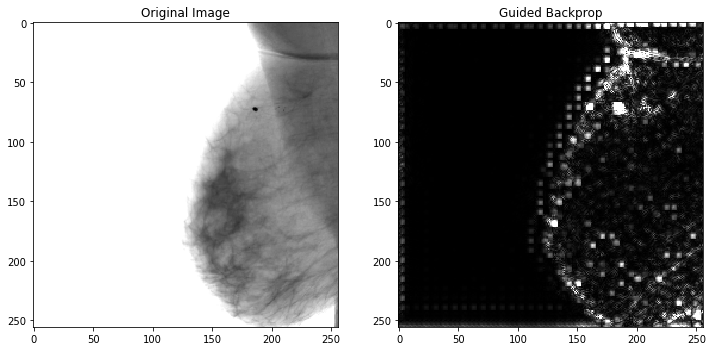

In [13]:
##### TESTING CODE
i=23
r=data.one_item(data.valid_ds.x[i])
r[0].requires_grad = True
# target = int(data.valid_dl.y[i])
target = r[1].cpu().numpy()[0]
print(target)

guided_grads = GBP.generate_gradients(r[0], target)
# Save colored gradients
save_gradient_images(guided_grads, 'snake_grad' + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)

plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
# plt.text(10,1200,"Label : {}".format(target))
plt.imshow(r[0].detach().cpu().numpy()[0].transpose((1,2,0))[:,:,0],cmap='gray')
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(grayscale_guided_grads[0],cmap='gray')
plt.title("Guided Backprop")


plt.show()

In [14]:
e=r[0].detach().cpu().numpy()[0].transpose((1,2,0))[:,:,0]

In [34]:
e.shape

(256, 256)

In [16]:
import os
os.getcwd()

'/home/santhosr/Documents/Birad/FastAI/RaceClassification/Visualization'